# Pattern Recognition - Ex. 2: First Group Task
*Group 7*

## Multi-Layer Perceptron (MLP)

The MLP in this exercise was implemented following the article ´MLP Learning in TensorFlow´ on [GeeksForGeeks](https://www.geeksforgeeks.org/deep-learning/multi-layer-perceptron-learning-in-tensorflow/).

#### Imports

In [22]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from sklearn.model_selection import train_test_split

#### Set Project Parameters

In [23]:
# File paths for training and testing data
TRAIN_TSV = '../MNIST-full/gt-train.tsv'
TEST_TSV = '../MNIST-full/gt-test.tsv'

# Hyperparameters to test
HIDDEN_SIZES = [32, 64, 128, 256]
LEARNING_RATES = [0.0001, 0.001, 0.01]

# Training settings
EPOCHS = 15
BATCH_SIZE = 250
VALIDATION_SPLIT = 0.2

#### Loading Local MNIST-Dataset

Although the MNIST-dataset could have been loaded more easily via the TensorFlow library, the local version was used.  

In [24]:
# Loads local MNIST-dataset from given TSV file
def load_data(tsv_path):
    # Read given TSV file with rows of format: <image_path>\t<label>
    # Use tab as separator and store data in a DataFrame with columns 'path' and 'label'
    df = pd.read_csv(tsv_path, sep='\t', header=None, names=['path', 'label'])
    
    # Initialize empty list to hold image data
    images = []

    # Iterate over each image path in the DataFrame to load and process images
    for path in df['path']:
        # Open image, convert to numpy array, normalize pixel values to [0, 1] and append to image data list
        img = Image.open("../MNIST-full/" + path)
        img_array = np.array(img, dtype=np.float32) / 255.0
        images.append(img_array)

    # Convert list of images to numpy array
    images = np.array(images)

    # Extract labels column as separate list
    labels = df['label'].values

    return images, labels


# Load training and test data from specified TSV files
x_full, y_full = load_data(TRAIN_TSV)
x_test, y_test = load_data(TEST_TSV)

To ensure consistency across reruns of experiments, we split the full training dataset into training and validation sets.

In [25]:
# Split full training data into consistent training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    x_full, y_full, test_size=VALIDATION_SPLIT, random_state=1
)

#### MLP: Building and Compiling the Model

In [26]:
# Build and compile MLP model with given hyperparameters for hidden size and learning rate
def create_mlp(hidden_size, learning_rate):

    # Build MLP model with one required hidden layer
    model = Sequential([
        # Reshape 28x28 images into 784-dimensional input vectors
        Flatten(input_shape=(28, 28)),
        # Hidden layer with parametrized size
        Dense(hidden_size, activation='relu'),
        # Output layer with 10 classes for digits 0-9
        Dense(10, activation='softmax')
    ])

    # Compile MLP model with Adam optimizer, sparse categorical crossentropy loss function and accuracy metric
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

#### MLP: Training the Model

This section trains the model with the previously defined hyperparameters and stores the results (incl. the training history and used hyperparameters) in a dictionary.

In [ ]:
# Create dictionary to hold training results
results = {}

# Iterate over hyperparameter combinations to train the MLP models
for hidden_size in HIDDEN_SIZES:
    for learning_rate in LEARNING_RATES:
        
        # Name model based on hyperparameter values
        model_name = f"hs_{hidden_size},lr_{learning_rate}"
        
        # Create MLP model with current hyperparameters 
        model = create_mlp(hidden_size, learning_rate)
        
       # Train model with specified training settings to return a training history
        model_history = model.fit(
            x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=(x_val, y_val),
        )
        
        # Update results with current hyperparameters and training history
        results[model_name] = {
            'hidden_size': hidden_size,
            'lr': learning_rate,
            'history': model_history.history,
            'model': model
        }

#### Plots for Loss and Accuracy of Training Results

Displays plots for the loss and accuracy on the training set and validation set with respect to the training epochs and the different hyperparameters (`Hidden Size` and `Learning Rate`), i.e. different MLP-models.

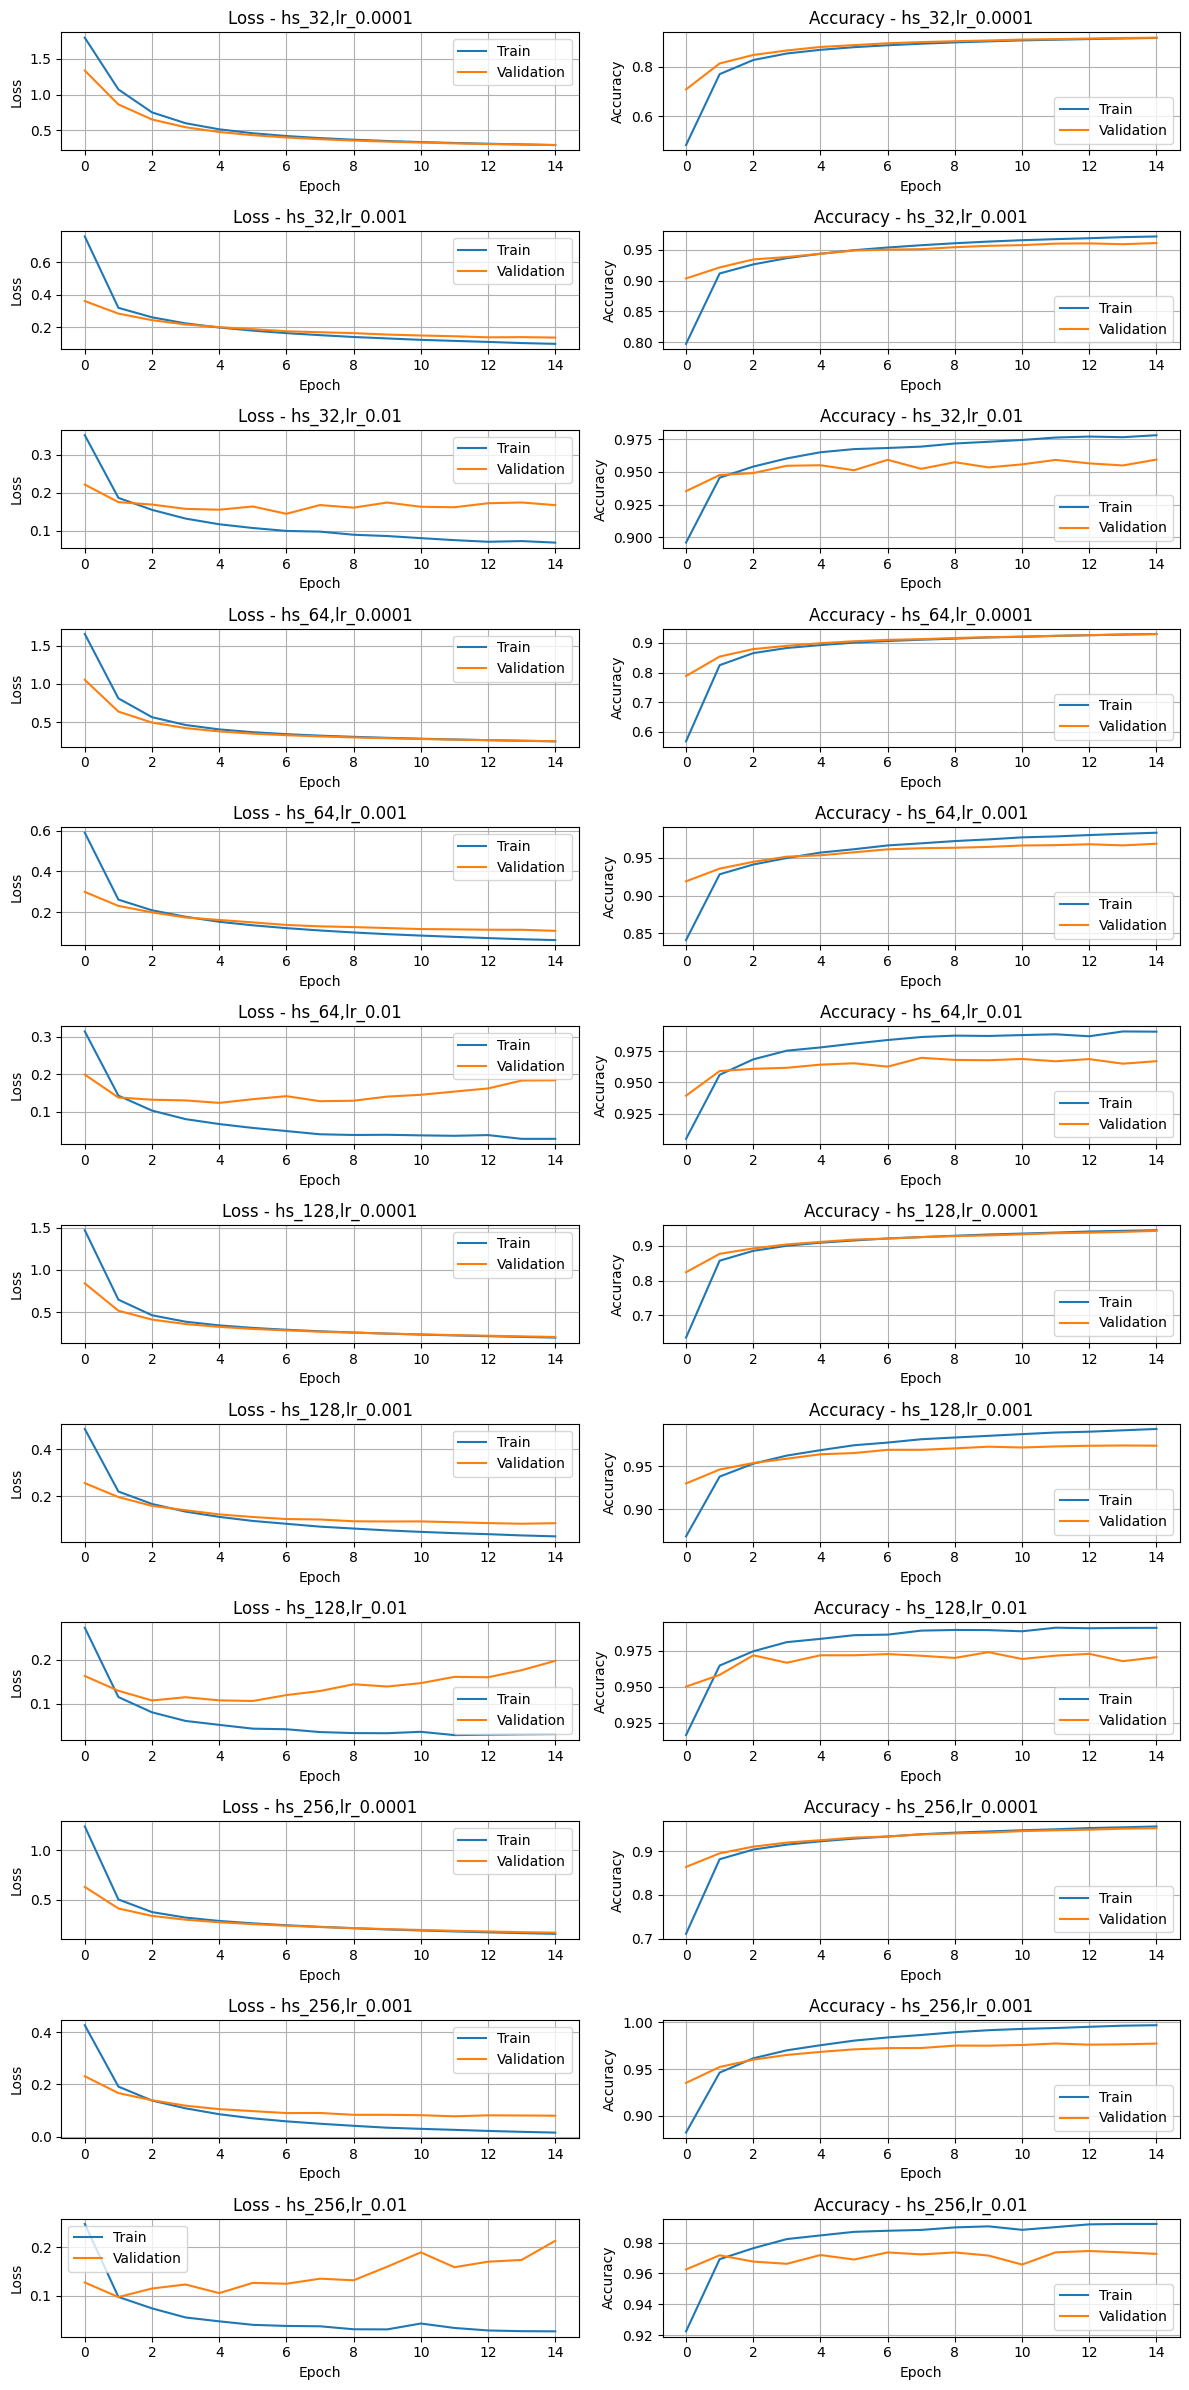

In [28]:
# Structure subplots in relation to number of hyperparameter combinations, i.e. number of models/results
fig, axes = plt.subplots(len(results), 2, figsize=(12, 2 * len(results)))

# Iterate over results to plot loss and accuracy
for idx, (model_name, data) in enumerate(results.items()):
    # Extract training history
    history = data['history']
    
    # Loss plot
    axes[idx, 0].plot(history['loss'], label='Train')
    axes[idx, 0].plot(history['val_loss'], label='Validation')
    axes[idx, 0].set_title(f'Loss - {model_name}')
    axes[idx, 0].set_xlabel('Epoch')
    axes[idx, 0].set_ylabel('Loss')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True)
    
    # Accuracy plot
    axes[idx, 1].plot(history['accuracy'], label='Train')
    axes[idx, 1].plot(history['val_accuracy'], label='Validation')
    axes[idx, 1].set_title(f'Accuracy - {model_name}')
    axes[idx, 1].set_xlabel('Epoch')
    axes[idx, 1].set_ylabel('Accuracy')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True)

plt.tight_layout()
plt.show()

#### Evaluating the Best Model

Find the best model (i.e. best combination of hyperparameters) based on the best validation accuracy.  
Upon finding the best model, evaluate it using the test dataset.

In [29]:
# Finds the name of the best model based on the highest validation accuracy
best_name = max(results.keys(), key=lambda k: max(results[k]['history']['val_accuracy']))

# Silently evaluate the best model on the test dataset
test_loss, test_acc = results[best_name]['model'].evaluate(x_test, y_test, verbose=0)

#### Results

Summarizes the results by listing all trained models of various hyperparameter combinations with their validation accuracy.  
Based on the best validation accuracy, the best model is shown along with its accuracy for the test dataset.


In [30]:
print("RESULTS SUMMARY")
print("*"*50)
print("Model Name\t\tValidation Accuracy")
print("*"*50)

for name, data in results.items():
    val_acc = max(data['history']['val_accuracy'])
    print(f"{name:20s}\t{val_acc:.4f}")

print("*"*50)
print(f"Best Model:\t\t{best_name}")
print(f"Test Accuracy:\t\t{test_acc:.4f}")

RESULTS SUMMARY
**************************************************
Model Name		Validation Accuracy
**************************************************
hs_32,lr_0.0001     	0.9185
hs_32,lr_0.001      	0.9608
hs_32,lr_0.01       	0.9594
hs_64,lr_0.0001     	0.9298
hs_64,lr_0.001      	0.9688
hs_64,lr_0.01       	0.9696
hs_128,lr_0.0001    	0.9423
hs_128,lr_0.001     	0.9737
hs_128,lr_0.01      	0.9740
hs_256,lr_0.0001    	0.9529
hs_256,lr_0.001     	0.9774
hs_256,lr_0.01      	0.9745
**************************************************
Best Model:		hs_256,lr_0.001
Test Accuracy:		0.9784
